# Encodings and sentence embeddings for sentiment analysis

## Imports

In [ ]:
import nltk;  from nltk import word_tokenize; from nltk.corpus import words; 
nltk.download('punkt'); nltk.download('stopwords'); nltk.download('words'); 
import pandas as pd 
import numpy as np
import multiprocessing; import pickle; import time; import string
from sklearn import metrics; import sklearn; 
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder; 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer;
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline 
import matplotlib.pyplot as plt

In [ ]:
!pip install hypopt
!pip install -U sentence-transformers;
import pandas as pd;import numpy as np ;from sklearn.model_selection import train_test_split; from sklearn.model_selection import GridSearchCV, PredefinedSplit
import nltk; from gensim.models import Word2Vec;nltk.download('punkt');nltk.download('stopwords'); import time; from hypopt import GridSearch;  from prettytable import PrettyTable;
from nltk.corpus import stopwords;from nltk.stem.snowball import EnglishStemmer;from nltk import word_tokenize; from matplotlib import collections as matcoll
from sentence_transformers import SentenceTransformer; from sentence_transformers.util import cos_sim; import matplotlib.pyplot as plt 

## Dataset

Downloading the dataset.

The dataset is a list of reviews, containing the text and the sentiment of the review; 1 represents a positive review, while 0 represents a negative review. 

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1oDvIo7sMAlxdF82uMXkYEmoeV7P4evcs 

df = pd.read_csv('./hw3_data.csv', delimiter = ',', header =  None, names = ['review', 'type'])
df.drop(np.where(df.isna())[0], inplace = True)

## Tf-idf encoding
In this part, we will perform a tf-idf encoding of the data,
and then train a classifier, optimising its hyper-parameters.

The goal is to maximise the f1-score on the test set.

### Splitting the dataset
Dividing the dataset into training set (85%) and test set (15%).

In [ ]:
x = df['review'].to_numpy()
y = df['type'].to_numpy()

train_x, test_x, train_y, test_y = sklearn.model_selection.train_test_split(x, y, test_size=0.15, shuffle=True, random_state = 2468) 

### Tf-idf Vectorizer
Creating an object that performs a tf-idf transformation on the data that also strip accents and a dictionary containing configurations for the tf-idf vectorizer.

In [ ]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(strip_accents = 'ascii', preprocessor = None)

stemmer = nltk.stem.snowball.EnglishStemmer()
english_stopwords = set(nltk.corpus.stopwords.words('english'))
word_list = words.words()

def stop(text):
	nostop_text = [ word for word in text  if word not in english_stopwords]
	return nostop_text

vectorizer_config = {'vect__tokenizer': [None, stop],
                     'vect__ngram_range': [(1, 1), (1, 2)],
                     'vect__norm': ['l1', 'l2']}

### Classifier pipeline

In [ ]:
cores = multiprocessing.cpu_count()

LR = LogisticRegression(n_jobs = cores)
RF = RandomForestClassifier(n_jobs = cores)

LR_config = {'C': [0.01, 0.05, 0.1, 0.5, 1]}
RF_config = {'n_estimators': [10, 50, 75, 100, 125]}
             
# Logistic Regression             
pipeline_LR = sklearn.pipeline.Pipeline([('vect', vectorizer), ('LR', LR)])

parameters_LR = {'vect__tokenizer': vectorizer_config['vect__tokenizer'],
                 'vect__ngram_range': vectorizer_config['vect__ngram_range'],
                 'vect__norm': vectorizer_config['vect__norm'],
                 'LR__C': LR_config['C']
                }

grid_search_LR = sklearn.model_selection.GridSearchCV(pipeline_LR, parameters_LR, scoring = 'f1', cv = 3)

LR_hyper = grid_search_LR.fit(train_x, train_y)

# Random Forest
pipeline_RF = sklearn.pipeline.Pipeline([('vect', vectorizer), ('RF', RF)])

parameters_RF = {'vect__tokenizer': vectorizer_config['vect__tokenizer'],
                 'vect__ngram_range': vectorizer_config['vect__ngram_range'],
                 'vect__norm': vectorizer_config['vect__norm'],
                 'RF__n_estimators': RF_config['n_estimators']
                }

random_search_RF = sklearn.model_selection.RandomizedSearchCV(pipeline_RF, parameters_RF, scoring = 'f1', cv = 3)

RF_hyper = random_search_RF.fit(train_x, train_y)



### Top-3 configurations boxplots on f1-score

In [ ]:
LR_1_df=pd.DataFrame.from_dict(LR_hyper.cv_results_).sort_values('mean_test_score',ascending=False).rename(columns = {'param_LR__C': 'C', 'param_vect__tokenizer': 'tokenizer', 'param_vect__norm': 'norm',	'param_vect__ngram_range': 'ngram_range'})

RF_1_df = pd.DataFrame.from_dict(RF_hyper.cv_results_).sort_values('mean_test_score',ascending=False).rename(columns = {'param_vect__tokenizer': 'tokenizer', 'param_vect__norm': 'norm',	'param_vect__ngram_range': 'ngram_range',	'param_RF__n_estimators': 'n_estimators'})   

dict_LR = {}; dict_RF = {}

for i in range(3): 

  mean_LR = LR_1_df.iloc[i, 12]; sd_LR = LR_1_df.iloc[i, 13]
  mean_RF = RF_1_df.iloc[i, 12]; sd_RF = RF_1_df.iloc[i, 13]
  dict_LR[f"{i+1}"] = [mean_LR, mean_LR - sd_LR, mean_LR + sd_LR]
  dict_RF[f"{i+1}"] = [mean_RF, mean_RF - sd_RF, mean_RF + sd_RF]

plt.figure(figsize=(16, 8));

ax1 = plt.subplot(1,2,1); ax1.set_title('Logistic Regression');
ax2 = plt.subplot(1,2,2); ax2.set_title('Random Forest');

ax1.set_xticklabels(dict_LR.keys()); ax2.set_xticklabels(dict_RF.keys());
ax1.boxplot(dict_LR.values(), patch_artist=True); ax2.boxplot(dict_RF.values(), patch_artist=True);

### Confusion matrix for best configurations

In [ ]:
# Logistic Regression
pipeline_LR = sklearn.pipeline.Pipeline([('vect', vectorizer), ('LR', LR)])

pipeline_LR.set_params(**{'LR__C':1, 'vect__ngram_range': (1,2), 'vect__norm':'l2', 'vect__tokenizer':None})

pipeline_LR.fit(train_x,train_y)

pred_test_y = pipeline_LR.predict(test_x)

confusion_matrix = metrics.confusion_matrix(test_y, pred_test_y)
print("Confusion Matrix: LR top configuration\n",pd.DataFrame(confusion_matrix))
print()

# Random Forests
pipeline_RF = sklearn.pipeline.Pipeline([('vect', vectorizer), ('RF', RF)])

pipeline_RF.set_params(**{'RF__n_estimators':125, 'vect__ngram_range': (1,2), 'vect__norm':'l2', 'vect__tokenizer':None})

pipeline_RF.fit(train_x,train_y)

pred_test_y = pipeline_RF.predict(test_x)

confusion_matrix = metrics.confusion_matrix(test_y, pred_test_y)
print("Confusion Matrix: RF top configuration\n",pd.DataFrame(confusion_matrix))

## Onehot encoding

In this part, we will perform a one-hot encoding of the data, then train a classifier, optimising its hyper-parameters.

The goal is to maximise accuracy on the test set.

In [ ]:
def text_preprocessing(text):
  tkn = word_tokenize(text.lower().translate(str.maketrans('', '', string.punctuation)), language='english')
  return [stemmer.stem(w) for w in tkn if ((w not in english_stopwords) and not w.isdigit())]

D = []

for doc in train_x:
   tokens = text_preprocessing(doc)
   for tkn in tokens: D.append(tkn)

D = [w for w in set(D) if w in word_list]

vectorizer = CountVectorizer(binary = True, strip_accents='ascii', preprocessor = lambda x: ' '.join(text_preprocessing(x)), vocabulary = D)

mat = vectorizer.fit_transform(train_x)
mat_test = vectorizer.fit_transform(test_x)

### PCA on the data
Before training the classifier we transform the data using Principal Component Analysis estimating and selecting the best number of components.

In [ ]:
scaler = StandardScaler()

mat = scaler.fit_transform(mat.toarray()) #we want words on cols to reduce them

pca = PCA(n_components=100, random_state =2468) #for sure we can't handle more
pca_train = pca.fit_transform(mat) 

cum_var = np.cumsum(pca.explained_variance_ratio_)

### Scree-plot

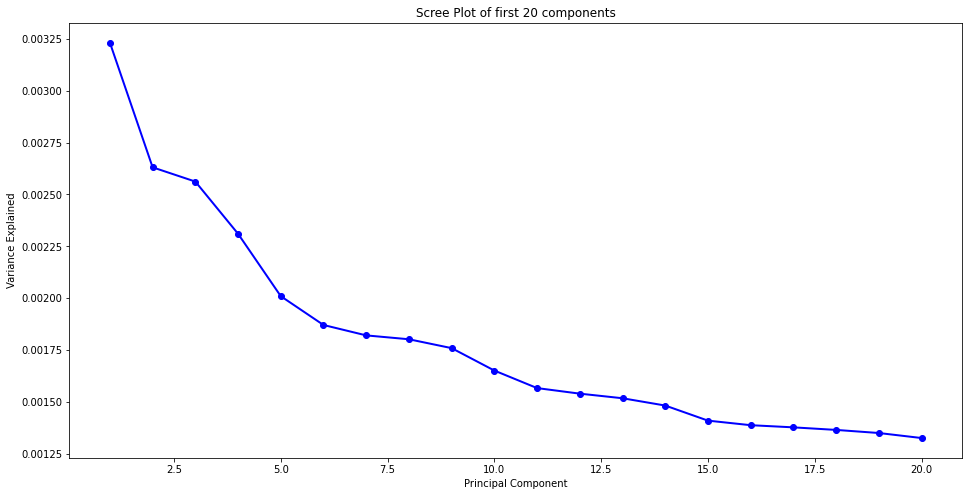

In [ ]:
plt.figure(figsize=(16, 8))

values = range(1,21)

plt.plot(values, pca.explained_variance_ratio_[:20], 'o-', linewidth=2, color='blue')
plt.title('Scree Plot of first 20 components')
plt.xlabel('Principal Component');
plt.ylabel('Variance Explained');

pca_train_red = pca_train[:,:10] # take first 10 components

mat_test = scaler.transform(mat_test.toarray()) #apply pca to the test
pca_test = pca.transform(mat_test)
pca_test = pca_test[:,:10] 

### KNeighborsClassifier
Constraints:
  * The algorithm used must be **"brute"**.
  * No *parallelization* 
  * A **9-fold** Cross-Validation must be performed
  * Test **exactly 20** configurations
  * Optimisation CANNOT take longer than **100 seconds**

In [ ]:
clf = KNeighborsClassifier(algorithm='brute')

param_grid = {'n_neighbors': [1,2,3], 
              'metric':['cosine','chebyshev','cityblock','euclidean'],
              'weights' : ['uniform','distance']}

rs = RandomizedSearchCV(clf, param_distributions=param_grid, scoring='accuracy', cv=9, n_iter = 20)

rs.fit(pca_train_red,train_y)

neigh = KNeighborsClassifier(algorithm ='brute',weights ='distance', n_neighbors= 3, metric ='cityblock').fit(pca_train_red, train_y)

disp = ConfusionMatrixDisplay.from_estimator(neigh,pca_test,test_y,cmap=plt.cm.Blues)

## Transformers
In this part, we will use a Transformer to obtain sentence embeddings for each document.

We will then train a classifier, optimising its hyper-parameters.

The goal is to maximise precision on the test set, but it is necessary to have a recall of **at least 70%**, according to the optimisation results.


### Validation set
Separating the training set into two parts: training set and validation set, with a **75/25 split**.

In [ ]:
train_x, val_x, train_y, val_y = sklearn.model_selection.train_test_split(train_x, train_y, test_size=0.25, shuffle=True, random_state = 2468) 

### Sentence transformers

In [ ]:
#YOUR CODE STARTS HERE#

model_1 = SentenceTransformer("paraphrase-MiniLM-L3-v2")
model_2 = SentenceTransformer("all-MiniLM-L6-v2")

# paraphrase-MiniLM-L3-v2
emb_1_train = model_1.encode(train_x)
emb_1_val = model_1.encode(val_x)
emb_1_test = model_1.encode(test_x)

# all-MiniLM-L6-v2
emb_2_train = model_2.encode(train_x)
emb_2_val = model_2.encode(val_x)
emb_2_test = model_2.encode(test_x)

### Classifier pipeline

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier()

# Grid-search all parameter combinations using a validation set.
param_grid =  {'leaf_size': [10, 20, 30], 'n_neighbors': [3, 5, 10, 15], 'p': [1, 2]}

# paraphrase-MiniLM-L3-v2
opt_1 = GridSearch(model = KNN, param_grid = param_grid)
opt_1.fit(emb_1_train, train_y, emb_1_val, val_y)

# all-MiniLM-L6-v2
opt_2 = GridSearch(model = KNN, param_grid = param_grid)
opt_2.fit(emb_2_train, train_y, emb_2_val, val_y)


# Results

In [ ]:
x = []; y = []; 
for i in range(len(opt_1.param_scores)):
  x.append(opt_1.param_scores[i][0])
  y.append(opt_1.param_scores[i][1])

z = []; w = [];
for i in range(len(opt_2.param_scores)):
  z.append(opt_2.param_scores[i][0])
  w.append(opt_2.param_scores[i][1])


t = PrettyTable(['Parameters', 'Accuracy'])
t_1 = PrettyTable(['Parameters', 'Accuracy']) 
for i in list(zip(x,y)):
    t.add_row(i)
for i in list(zip(z,w)):
    t_1.add_row(i)

print("Model 1: \n",t)
print("Model 2: \n",t_1)

x_1 = np.arange(1,25)
x_2 = np.arange(1,25)

lines = []; lines_2 = [];

for i in range(len(x_1)):
    pair=[(x_1[i],0), (x_1[i], y[i])]
    lines.append(pair)
    
    pair_1=[(x_2[i],0), (x_2[i], w[i])]
    lines_2.append(pair_1)

Model 1: 
 +----------------------------------------------+--------------------+
|                  Parameters                  |      Accuracy      |
+----------------------------------------------+--------------------+
| {'leaf_size': 10, 'n_neighbors': 15, 'p': 1} | 0.7348255696713047 |
| {'leaf_size': 20, 'n_neighbors': 15, 'p': 1} | 0.7348255696713047 |
| {'leaf_size': 30, 'n_neighbors': 15, 'p': 1} | 0.7348255696713047 |
| {'leaf_size': 30, 'n_neighbors': 15, 'p': 2} | 0.7324057269610809 |
| {'leaf_size': 10, 'n_neighbors': 15, 'p': 2} | 0.7324057269610809 |
| {'leaf_size': 20, 'n_neighbors': 15, 'p': 2} | 0.7324057269610809 |
| {'leaf_size': 30, 'n_neighbors': 10, 'p': 2} | 0.7162734422262553 |
| {'leaf_size': 10, 'n_neighbors': 10, 'p': 2} | 0.7162734422262553 |
| {'leaf_size': 20, 'n_neighbors': 10, 'p': 2} | 0.7162734422262553 |
| {'leaf_size': 30, 'n_neighbors': 10, 'p': 1} | 0.7124420246017342 |
| {'leaf_size': 10, 'n_neighbors': 10, 'p': 1} | 0.7124420246017342 |
| {'leaf_

### Confusion Matrix
Confusion matrix of the combination of hyper-parameters that achieves the best performance.

----- CONFUSION MATRIX -----



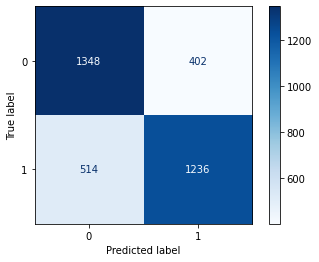

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(opt_1.model, emb_1_test, test_y, cmap=plt.cm.Blues) # opt_1.model is the best combination model

### 512 length sentence embeddings

Total time taken for the pipeline: 2.893823039531708

----- CONFUSION MATRIX -----



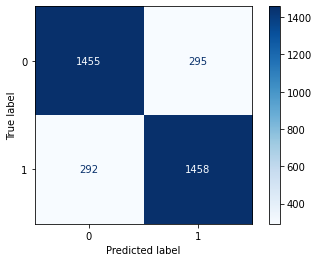

In [ ]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v2') # embeddings of length 512

emb_1_train = model.encode(train_x)
emb_1_val = model.encode(val_x)
emb_1_test = model.encode(test_x)

lr = LogisticRegression(n_jobs = -1)

param_grid =  {'C': [0.1, 0.5, 1, 5, 10, 20]}

split_index = [-1]*len(emb_1_train) + [0]*len(emb_1_val)
X = np.concatenate((emb_1_train, emb_1_val), axis=0)
y = np.concatenate((train_y, val_y), axis=0)
pds = PredefinedSplit(test_fold = split_index)

# Use PredefinedSplit in GridSearchCV
opt_1 = GridSearchCV(estimator=lr, cv=pds, param_grid=param_grid, scoring='precision')
opt_1.fit(X, y)


lr = opt_1.best_estimator_

print('----- CONFUSION MATRIX -----')
print()
ConfusionMatrixDisplay.from_estimator(lr, emb_1_test, test_y, cmap=plt.cm.Blues);